# Flyouts
During a play, it is decided whether it will be a groundout, flyout, or hit. This notebook encompasses all baserunner advancement possibilities after a flyout has been decided.

So far, we can confirm that baserunner indulgence is positively correlated with advancing. The formulas are still unclear.


In [1]:
# Load Dataframe

import glob

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-flyout.csv")

df = pd.concat((pd.read_csv(f, dtype={'roll': str}) for f in all_files), ignore_index=True)

# seasons = [11,12,13,14]
seasons = [11,12]
df = df[df['season'].isin(seasons) & df['stadium_id'].isna()]
df = df[df['roll'] != '[]'] # The unpacking code thinks empty is 1 roll, so exclude it here.

# Up to 2 rolls for flyouts, so split them up here
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
print(df[[len(rolls) == 2 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
print(df[[len(rolls) == 1 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
# print(np.count_nonzero([len(rolls) == 3 for rolls in df['roll'].to_list()]))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2',], index = df.index)
df[['roll1','roll2']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

print(f"{len(df)} events before filtering.")

In [ ]:
# Vibes

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0
df.loc[df["runner_on_second_mods"].astype(str).str.contains("SCATTERED"), "runner_on_second_vibes"] = 0
df.loc[df["runner_on_third_mods"].astype(str).str.contains("SCATTERED"), "runner_on_third_vibes"] = 0

df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()

for base in ["first","second","third","third_hh"]:
    for attr in [
        f"runner_on_{base}_base_thirst",
        f"runner_on_{base}_continuation",
        f"runner_on_{base}_ground_friction",
        f"runner_on_{base}_indulgence",
        f"runner_on_{base}_laserlikeness",
    ]:
        df[attr + "_scaled"] = df[attr] * df[f"runner_on_{base}_multiplier"]
        df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_on_{base}_vibes"])
df = df.copy()

for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df = df.copy()


for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_scaled"] = df[attr] * df["fielder_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["fielder_vibes"])
df = df.copy()

len(df)

3334

In [ ]:
# Ignore multipliers and some mods

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED"]:
    df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]

df = df[
    (df["pitcher_multiplier"] == 1)
    & (df["batter_multiplier"] == 1)
    & (df["fielder_multiplier"] == 1)
    & (df["runner_on_first_multiplier"] == 1)
    & (df["runner_on_second_multiplier"] == 1)
    & (df["runner_on_third_multiplier"] == 1)
    & (df["runner_on_third_hh_multiplier"] == 1)
]

print(len(df))

# Begin Selection

In [ ]:
n_outliers = 0

## Runner on First

### [0] -> [0] (fail) or [1] (pass)

,roll1_log,runner_on_first_indulgence_with_vibe_log
14,-0.035972,-0.094988
16,-0.430550,-0.094988
17,-0.420402,-1.434137
48,-1.521141,-0.856431
51,-1.454790,0.220643
...,...,...
27860,-0.920244,-0.458884
27862,-2.086315,-1.947502
27864,-1.192148,-1.947502
27865,-0.370664,-0.400734


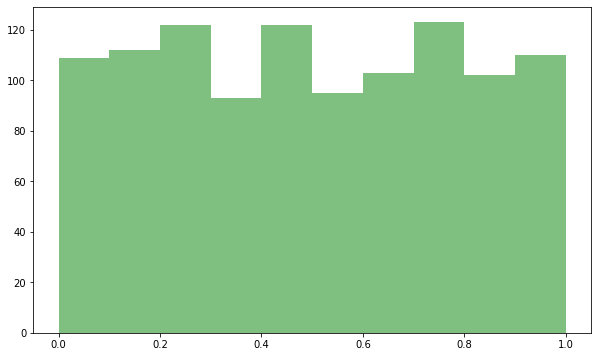

In [ ]:
dfc = df[df['baserunners'] == "[0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'].isin(["[0]","[1]"])]
# dfc = dfc[round(dfc['roll1'],6) != 0.002127]
# print(len(dfc[~dfc['roll2'].isna()]))
dfc["passed"] = dfc['baserunners_next'].str.contains("[1]")
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
dfc['roll1_log'] = dfc['roll1'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_log'] = dfc['runner_on_first_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_pow'] = dfc['runner_on_first_indulgence_with_vibe']**3.5
X = dfc[
    [
        "roll1_log",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_first_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[1030    3]
 [   1   57]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1033
        True       0.95      0.98      0.97        58

    accuracy                           1.00      1091
   macro avg       0.97      0.99      0.98      1091
weighted avg       1.00      1.00      1.00      1091

0.9963336388634281


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[1.9683487]


[(-3.9381952433731926, 'runner_on_first_indulgence_with_vibe_log'),
 (1.0, 'roll1_log')]

[-1.9683487]
(-1.0, 'roll1_log')
(3.9381952433731926, 'runner_on_first_indulgence_with_vibe_log')


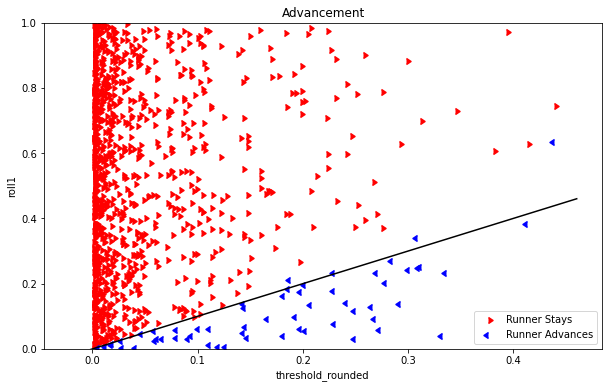

In [ ]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0 + 0.125 * dfc["runner_on_first_indulgence_with_vibe_pow"]
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


4 outliers


,passed,roll1,threshold_rounded,event_type,inning,ballpark_mysticism,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,weather,season,day,game_id,play_count
10592,True,0.231545,0.229552,flyout,6,0.5,Alexander Horne,NaN,LOVE;EXTRA_STRIKE;BASE_DEALING,Marco Stink,NaN,Leach Ingram,NaN,NaN,Weather.BLACK_HOLE,12,55,14f51890-2991-427d-8c66-1a86ada1976a,229
10933,True,0.635641,0.438408,flyout,5,0.5,Beck Whitney,NaN,LIFE_OF_PARTY;ELECTRIC,Fitzgerald Blackburn,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,Weather.BLACK_HOLE,12,59,71c9496b-b22e-4c76-8ff4-762e10f6ec3c,238
11653,True,0.211741,0.187615,flyout,6,0.5,Fran Beans,SWIM_BLADDER,NaN,Lance Serotonin,NaN,Grollis Zephyr,NaN,NaN,Weather.PEANUTS,12,68,8a8b63bf-2e36-44e4-b807-a9c6879d81cc,256
25155,True,0.341339,0.308796,flyout,7,0.5,Valentine Games,NaN,NaN,Caleb Novak,FIRE_EATER,Qais Dogwalker,FRIEND_OF_CROWS,LIFE_OF_PARTY;ELECTRIC,Weather.BIRDS,12,70,85d00119-0076-462e-ab0c-ba201d727827,242


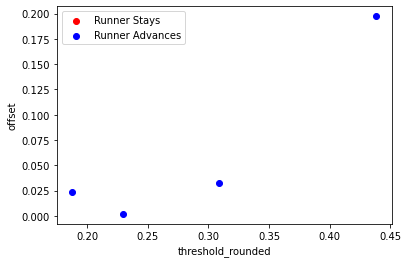

In [ ]:
# Plot outliers
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "ballpark_mysticism",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runner on Second

### [1] -> [1] (fail) or [2] (pass)

,roll1_log,runner_on_second_indulgence_with_vibe_log
7,-1.639962,0.218939
24,-1.293696,-0.748382
57,-2.141360,-4.584419
58,-1.317733,-0.650475
96,-0.765331,-0.403622
...,...,...
27616,-2.158056,-0.441809
27638,-0.877487,-0.856431
27809,-0.175570,-4.209818
27815,-2.882534,-1.029457


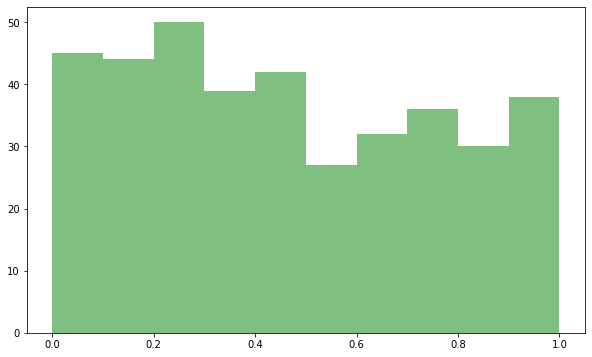

In [ ]:
dfc = df[df['baserunners'] == "[1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'].isin(["[1]","[2]"])]
# print(len(dfc[~dfc['roll2'].isna()]))
dfc["passed"] = dfc['baserunners_next'].str.contains("[2]")
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
# dfc['roll1'] = dfc['roll1'].apply(lambda x: x)
dfc['roll1_log'] = dfc['roll1'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_log'] = dfc['runner_on_second_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_pow'] = dfc['runner_on_second_indulgence_with_vibe']**3.5
y = dfc["passed"]
X = dfc[
    [
        "roll1_log",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_second_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
# y = X["passed"]
# X = X.drop("passed", axis=1)
X

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[270   5]
 [  8 100]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       275
        True       0.95      0.93      0.94       108

    accuracy                           0.97       383
   macro avg       0.96      0.95      0.96       383
weighted avg       0.97      0.97      0.97       383

0.9660574412532638


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[0.9740383]


[(1.0, 'roll1_log'),
 (-0.8953319530346888, 'runner_on_second_indulgence_with_vibe_log')]

[-0.9740383]
(0.8953319530346888, 'runner_on_second_indulgence_with_vibe_log')


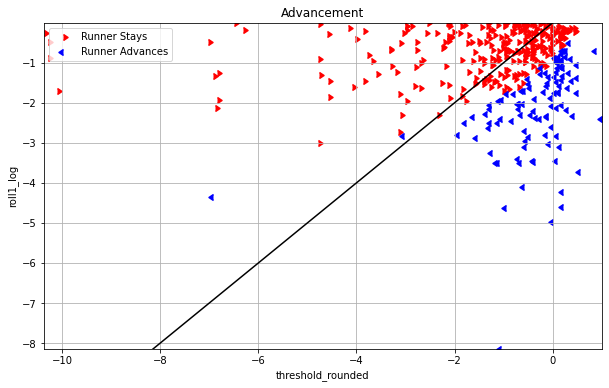

In [ ]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 1.5*dfc["runner_on_second_indulgence_with_vibe_log"]
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1_log":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.scatter(
#     dfc[~dfc["passed"]][x_val],
#     dfc[~dfc["passed"]]["roll1"],
#     color="red",
#     label="Runner Stays",
#     marker=CARETRIGHTBASE,
# )
# ax.scatter(
#     dfc[dfc["passed"]][x_val],
#     dfc[dfc["passed"]]["roll1"],
    
#     color="blue",
#     label="Runner Advances",
#     marker=CARETLEFTBASE,
# )
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1_log"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1_log"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1_log")
ax.set_title("Advancement")
ax.grid()
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")
ax.set_xlim(dfc["threshold_rounded"].min(),dfc["threshold_rounded"].max())
ax.set_ylim(dfc["roll1_log"].min(),dfc["roll1_log"].max())

ax.legend()


91 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
16871,0.004544,True,0.006835,0.002291,flyout,4,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,Malik Romayne,NaN,Alexandria Rosales,NaN,NaN,12,15,314e12bb-6e25-47a2-90bb-c1589aae16fc,150
13927,0.009744,True,0.402274,0.392531,flyout,3,NaN,NaN,BASE_INSTINCTS,Cudi Di Batterino,NaN,Coolname Galvanic,NaN,NaN,12,32,b24c1d2d-e351-455f-ab36-4cf43a095346,134
21016,0.012433,True,0.120194,0.107761,flyout,2,NaN,NaN,NaN,Greer Gwiffin,NaN,Gabriel Griffith,NaN,NaN,12,8,a13d92f8-8c26-46dc-a36f-38616926bc08,93
13803,0.019953,True,0.174650,0.154697,flyout,0,NaN,NaN,AFFINITY_FOR_CROWS,Joshua Watson,ALTERNATE,Oscar Vaughan,ALTERNATE,NaN,12,31,2bba13fc-886a-4baf-abbd-0e6f80ded5bc,18
10824,0.022347,True,0.263679,0.241332,flyout,5,NaN,NaN,NaN,Lawrence Horne,NaN,Cell Barajas,TRIPLE_THREAT,NaN,12,58,5f517aca-b59a-4afc-bd71-0ce5df02d416,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13911,1.690242,True,0.095214,-1.595028,flyout,1,NaN,NaN,BOTTOM_DWELLER,Randy Dennis,SIPHON;SWIM_BLADDER,Sixpack Santiago,TRIPLE_THREAT,LIFE_OF_PARTY;ELECTRIC,12,32,1284296e-1cc3-4929-8933-11ac2a742334,76
4119,1.843643,True,0.081598,-1.762045,flyout,2,NaN,NaN,AFFINITY_FOR_CROWS,Theo King,NaN,Parker Meng,ALTERNATE;PERK,LOVE;PARTY_TIME,11,93,2dfd21d7-81ec-498b-b16b-39c191f7635c,88
10382,1.967740,True,0.060818,-1.906922,flyout,1,NaN,NaN,NaN,Nagomi Nava,FIRE_EATER,Lars Taylor,SWIM_BLADDER,BASE_INSTINCTS,12,53,83448f50-1c00-46ac-b37a-75c698f19a1e,52
14101,3.093726,True,0.058504,-3.035222,flyout,2,NaN,NaN,LATE_TO_PARTY,Yusef Fenestrate,NaN,Nandy Slumps,NaN,NaN,12,34,d96a64eb-12c3-4d93-ae5d-eaf419cb2ef7,128


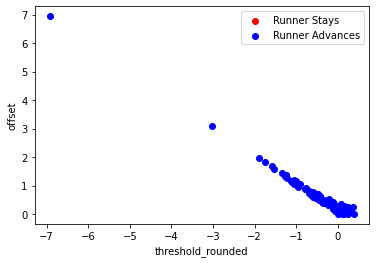

In [ ]:
# Outliers
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Runner on Third

### [2] -> [2] (fail) or [] (pass)

7        False
14       False
16       False
17       False
24       False
         ...  
27865    False
27866    False
27872    False
27874    False
27890    False
Name: baserunners, Length: 2141, dtype: bool
7         True
14       False
16       False
17       False
24       False
         ...  
27865    False
27866    False
27872    False
27874    False
27890    False
Name: baserunners_next, Length: 2141, dtype: bool


/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/1153447842.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["passed"] = (dfc['baserunners'] == "[2]") \
/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/1153447842.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")


,roll1,runner_on_third_indulgence_with_vibe
33,0.989935,1.407261
56,0.325904,1.112821
59,0.870317,0.703976
78,0.397576,0.399552
131,0.684485,0.731552
...,...,...
27773,0.371429,1.085418
27803,0.204793,0.571368
27812,0.048141,1.199163
27872,0.408737,0.728446


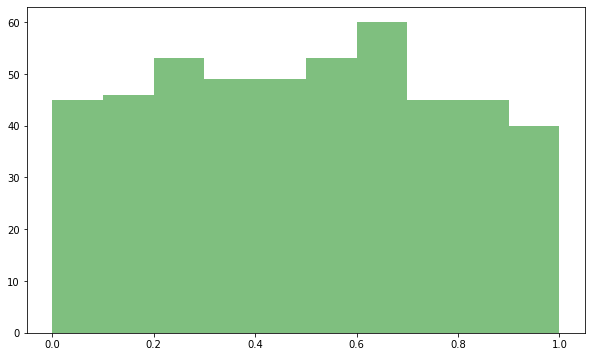

In [ ]:
# Bring in all situations with a runner on 3rd since the first roll is always to check if 3rd base advances
print(df['baserunners'] == "[2]")
print(df['baserunners_next'].isin(["[2]","[]"]))
dfc = df[ \
    ((df['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[2]","[]"]))) \
    | \
    ((df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 1, 0]","[1, 0]","[2, 0]"]))) \
    | \
    ((df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2, 1]","[1]","[2]"]))) \
    | \
    ((df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[2, 0]","[0]","[1]"]))) \
    ]
dfc["passed"] = ((dfc['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[1, 0]","[2, 0]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[1]","[2]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[1]","[0]"])))

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
X = dfc[
    [
        "roll1",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_third_indulgence_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[146  21]
 [ 19 299]]
              precision    recall  f1-score   support

       False       0.88      0.87      0.88       167
        True       0.93      0.94      0.94       318

    accuracy                           0.92       485
   macro avg       0.91      0.91      0.91       485
weighted avg       0.92      0.92      0.92       485

0.9175257731958762


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.40087617]


[(1.0, 'roll1'),
 (-0.37720544491666314, 'runner_on_third_indulgence_with_vibe')]

[0.40087617]
(0.37720544491666314, 'runner_on_third_indulgence_with_vibe')


/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/117082457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["threshold_rounded"] = 0.47 + 0.31 * dfc["runner_on_third_indulgence_with_vibe"]
/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/117082457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["threshold"] = -intercept_scaled[0]
/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/117082457.py:12: SettingWithCopyWarning: 
A value is trying to be se

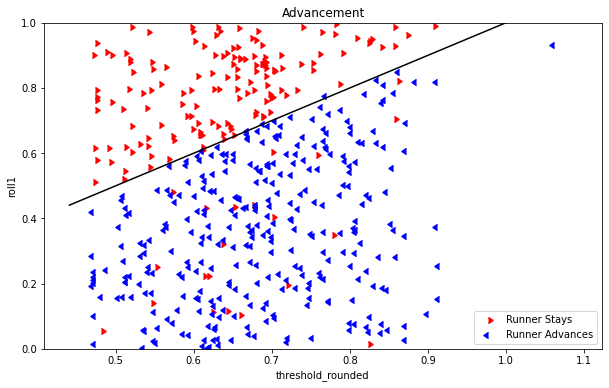

In [ ]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.47 + 0.31 * dfc["runner_on_third_indulgence_with_vibe"]

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


22 outliers


/var/folders/vh/yq87z4x91r9c8dp2w9g0c1c80000gn/T/ipykernel_55542/3775103384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
3782,-0.808730,False,0.014947,0.823677,flyout,1,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,Vito Kravitz,ALTERNATE,Sexton Wheerer,ALTERNATE;SUPERALLERGIC;FRIEND_OF_CROWS,NaN,11,88,9189a350-0fff-475a-9fde-41f33a31cb7e,57
2867,-0.552504,False,0.105098,0.657602,flyout,6,NaN,NaN,NaN,Christian Combs,FIRE_EATER,Montgomery Bullock,FRIEND_OF_CROWS;WILD,NaN,11,75,3f8c0642-59a8-4ead-bac9-ef7cf8eb09f1,206
237,-0.524777,False,0.116709,0.641486,flyout,6,Ortiz Lopez,FIRE_EATER,LOVE,Eduardo Woodman,NaN,Nicholas Mora,NaN,AFFINITY_FOR_CROWS,11,61,30e29942-85ab-4894-8f8e-09d9e0bfe15d,244
25212,-0.522646,False,0.195998,0.718645,flyout,4,NaN,NaN,LOVE;EXTRA_STRIKE;BASE_DEALING,Kline Greenlemon,NaN,Orville Manco,NaN,NaN,12,71,7ca2305e-a048-4bf5-ada1-09860dd4fe7d,168
3301,-0.507833,False,0.113725,0.621558,flyout,4,Kathy Mathews,ALTERNATE,NaN,Theodore Holloway,NaN,Sosa Hayes,NaN,NaN,11,81,ac20ee78-e56e-4c63-9465-4f31a8a6b0b3,163
26821,-0.428996,False,0.347811,0.776808,flyout,7,NaN,NaN,NaN,Oliver Mueller,NaN,Betsy Trombone,ALTERNATE;FRIEND_OF_CROWS,NaN,11,42,b9b7614a-5b8d-4403-90ec-da38a580faf5,223
11053,-0.427958,False,0.053568,0.481526,flyout,1,Jasper Blather,NaN,MAINTENANCE_MODE,Allison Abbott,NaN,Orville Manco,NaN,NaN,12,61,f2cc4e24-6db8-4c60-ab8a-0ba9c07ad687,81
16407,-0.404159,False,0.141108,0.545267,flyout,2,Siobhan Chark,SWIM_BLADDER,UNDERSEA,Mags Banananana,NaN,Agan Harrison,NaN,LATE_TO_PARTY,12,10,60aaa359-3e9d-41ac-80d7-dce60de03d17,104
11497,-0.394627,False,0.222044,0.616671,flyout,7,NaN,NaN,NaN,Gia Holbrook,NaN,Torus McGhee,NaN,MAINTENANCE_MODE,12,66,8f2922f6-1a23-4bf2-bb4b-37543fd406f2,245
16962,-0.387844,False,0.223941,0.611785,flyout,3,Nandy Fantastic,FIRST_BORN,BIRD_SEED,Kelvin Drumsolo,NaN,Torus McGhee,NaN,MAINTENANCE_MODE,12,16,093df7a2-6a5c-45d2-832a-9f93e42cc295,156


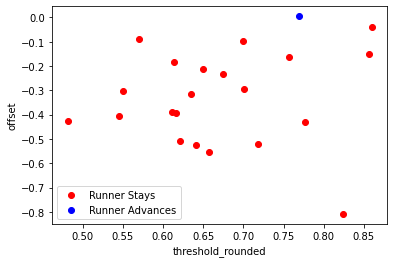

In [ ]:
# Outliers
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Runners on First and Second

### [1, 0] -> [1, 0]
DP (fail), Marytr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

144


KeyError: 'threshold_dp'

### [1, 0] -> [2, 1]
DP (fail), Marytr (pass), ???, ???. Last two are maybe fake advancement rolls

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll3'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [1, 0] -> [2, 0]
DP (fail), Marytr (pass), ???, ???. Last two are maybe fake advancement rolls

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll3'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runners on First and Third

### [2, 0] -> [0]
DP (fail), Martyr (pass), 3rd Advance (pass), 1st Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[(df['baserunners'] == "[2, 0]")]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 0] -> [1]
DP (fail), Martyr (pass), 3rd Advance (pass), 1st Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 0] -> [2, 1]
DP (fail), Martyr (pass), 3rd Advance (fail), ??? (unused). Last one is maybe fake advancement roll

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_dp",
        "roll1",
        "threshold_martyr",
        "roll2",
        # "threshold_advance_third",
        # "roll3",
        "event_type",
        "inning",
        # "batter_name",
        # "batter_mods",
        "runner_on_third_name",
        "runner_on_third_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        # "pitcher_name",
        # "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runners on Second and Third

### [2, 1] -> [1]
DP (unused), 3rd Advance (pass), 2nd Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2]
DP (unused), 3rd Advance (pass), 2nd Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2, 1]
DP (unused), 3rd Advance (fail), 2nd Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2, 2]
DP (unused), 3rd Advance (fail), 2nd Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"]) & (dfc["roll3"] < dfc["threshold_advance_second"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runners Holding Hands on Third

### [2, 2] -> []
DP (unused), 3rd Advance (pass), 3rd hh Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) & (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 2] -> [2]
DP (unused), 3rd Advance (fail), 3rd Advance hh (pass)
OR
DP (unused), 3rd Advance (pass), 3rd Advance hh (fail)
- We only have 3 examples of the former and none of the latter!

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) | (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 2] -> [2, 2]
DP (unused), 3rd Advance (fail), 3rd Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"]) & (dfc["roll3"] > dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Bases Loaded

### [2, 1, 0] -> [2, 1] (five rolls)
DP (fail), Martyr (pass), ???, ???, ???. Last three are maybe fake advancment rolls

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[(df['baserunners'] == "[2, 1, 0]") & (~df['roll5'].isna())]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll3'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll4'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll5'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1, 0] -> [2, 1, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1, 0] -> [1, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1, 0] -> [2, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Bases Overloaded

### [2, 1, 2, 0] -> [2, 0]
DP (fail), Martyr (fail), ???

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

In [ ]:
# How many outliers?
print(n_outliers)